# Module 4: Push Notifications DS

## Import libraries

In [ ]:
import os
import boto3
import logging
import numpy as np
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, confusion_matrix

logging.basicConfig(
    level=logging.INFO,  # Info level for general information
    format="%(asctime)s - %(levelname)s - %(message)s",
)

## Load dataset

In [13]:
load_dotenv()
AWW_API_KEY = os.getenv("AWW_API_KEY")
AWW_SECRET = os.getenv("AWW_SECRET")

s3 = boto3.client(
    's3',
    aws_access_key_id=AWW_API_KEY,
    aws_secret_access_key=AWW_SECRET
)
bucket_name = 'zrive-ds-data'
prefix = "groceries/box_builder_dataset/"

PROJECT_ROOT = Path().resolve().parent.parent
DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR.mkdir(exist_ok=True)

logging.info(f"Data folder: {DATA_DIR}")

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

for obj in response.get("Contents", []):
    file_key = obj["Key"]
    if file_key.endswith("/"):  # skip folder placeholders
        continue

    # Strip the first folder ('groceries/') and keep the inner folders
    relative_path = Path(*file_key.split("/")[1:])
    local_path = DATA_DIR / relative_path
    local_path.parent.mkdir(parents=True, exist_ok=True)

    if local_path.exists():
        logging.info(f"Already exists: {local_path}, skipping download.")
    else:
        s3.download_file(bucket_name, file_key, str(local_path))
        logging.info(f"Downloaded {local_path}")

2025-10-24 11:29:23,439 - INFO - Data folder: /Users/maria/Desktop/Zrive DS/zrive-ds/data


2025-10-24 11:29:23,965 - INFO - Already exists: /Users/maria/Desktop/Zrive DS/zrive-ds/data/box_builder_dataset/feature_frame.csv, skipping download.


In [14]:
df = pd.read_csv(DATA_DIR / "box_builder_dataset" / "feature_frame.csv")
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


## Milestone 1: exploration phase

### Filter to at least 5 items bought

In [16]:
orders_with_5plus = (
    df[df["outcome"] == 1]              # only buy orders
      .groupby("order_id")["variant_id"]
      .nunique()                        # count unique variant_id por order_id
      .loc[lambda x: x >= 5]            # take >= 5 items
      .index                            # get the order_id index
)

df_filtered = df[df["order_id"].isin(orders_with_5plus)]


In [17]:
logging.info(f"Original dataset size: {df.shape[0]} rows")
logging.info(f"Filtered dataset size: {df_filtered.shape[0]} rows")
df_filtered.head()

2025-10-24 11:29:40,676 - INFO - Original dataset size: 2880549 rows
2025-10-24 11:29:40,679 - INFO - Filtered dataset size: 2163953 rows


,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


### Prepare the data

Now, we split the data intro train (70%), validation (20%) and test (10%). We have to take into account that our data has a temporal feature, so we split them in time.

/var/folders/45/_kywt6y9647bq9fvcw_fkvrw0000gn/T/ipykernel_48818/2142189591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['order_date'] = pd.to_datetime(df_filtered['order_date'])


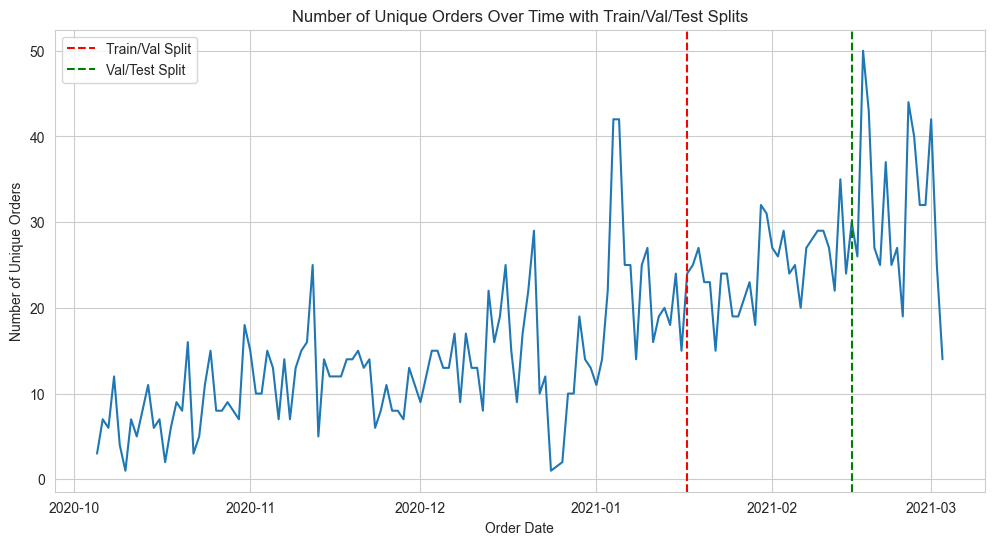

In [ ]:
df_filtered['order_date'] = pd.to_datetime(df_filtered['order_date'])
orders_per_date = df_filtered.groupby('order_date')['order_id'].nunique().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=orders_per_date, x='order_date', y='order_id')
train_size = int(0.7 * len(orders_per_date))
val_size = int(0.2 * len(orders_per_date))
train_end_date = orders_per_date['order_date'].iloc[train_size - 1]
val_end_date = orders_per_date['order_date'].iloc[train_size + val_size - 1]
plt.axvline(x=train_end_date, color='r', linestyle='--', label='Train/Val Split')
plt.axvline(x=val_end_date, color='g', linestyle='--', label='Val/Test Split')
plt.legend()
plt.title('Number of Unique Orders Over Time with Train/Val/Test Splits')
plt.xlabel('Order Date')
plt.ylabel('Number of Unique Orders')
plt.show()

In [ ]:
def temporal_split_by_order(
    df, 
    date_col, 
    order_col="order_id", 
    feature_cols=None,
    target_col="outcome", 
    train_size=0.7, 
    val_size=0.2, 
    test_size=0.1
):
    """
    Splits a DataFrame into train, validation, and test sets based on order date,
    ensuring no items from the same order appear in multiple splits.
    """
    if not abs(train_size + val_size + test_size - 1.0) < 1e-6:
        raise ValueError("train_size + val_size + test_size must equal 1.0")

    # Order unique orders by date
    orders_sorted = (
        df[[order_col, date_col]]
        .drop_duplicates()
        .sort_values(date_col)
    )

    n_orders = len(orders_sorted)
    train_end = int(train_size * n_orders)
    val_end = int((train_size + val_size) * n_orders)

    # Assign orders to splits
    train_orders = orders_sorted.iloc[:train_end][order_col]
    val_orders = orders_sorted.iloc[train_end:val_end][order_col]
    test_orders = orders_sorted.iloc[val_end:][order_col]

    # Filter DataFrame based on order assignments
    train_df = df[df[order_col].isin(train_orders)]
    val_df = df[df[order_col].isin(val_orders)]
    test_df = df[df[order_col].isin(test_orders)]

    # If feature_cols is specified, select only those columns along with target_col
    if feature_cols is not None:
        train_df = train_df[feature_cols + [target_col]]
        val_df = val_df[feature_cols + [target_col]]
        test_df = test_df[feature_cols + [target_col]]

    # Divide into X and y
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_val = val_df.drop(columns=[target_col])
    y_val = val_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]

    logging.info(f"Total unique orders: {n_orders}")
    logging.info(f"Train orders: {len(train_orders)} ({train_size*100:.1f}%)")
    logging.info(f"Val orders: {len(val_orders)} ({val_size*100:.1f}%)")
    logging.info(f"Test orders: {len(test_orders)} ({test_size*100:.1f}%)")
    logging.info(f"Train rows: {train_df.shape[0]}, Val rows: {val_df.shape[0]}, Test rows: {test_df.shape[0]}")

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = temporal_split_by_order(
    df=df_filtered,
    date_col="order_date",
    order_col="order_id",
    feature_cols=["product_type", "ordered_before", "abandoned_before", "active_snoozed", "set_as_regular", "global_popularity"],
    target_col="outcome"
)
logging.info(f"Shapes -> Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

2025-10-26 20:36:46,844 - INFO - Total unique orders: 2603
2025-10-26 20:36:46,844 - INFO - Train orders: 1822 (70.0%)
2025-10-26 20:36:46,845 - INFO - Val orders: 520 (20.0%)
2025-10-26 20:36:46,845 - INFO - Test orders: 261 (10.0%)
2025-10-26 20:36:46,846 - INFO - Train rows: 1446691, Val rows: 466801, Test rows: 250461
2025-10-26 20:36:46,882 - INFO - Shapes -> Train: (1446691, 6), Val: (466801, 6), Test: (250461, 6)


The next step is transforming the categorical features into numericals to train the model. As we have so many categories in `product_type` one-hot encoding would increase the df size a lot, so we have to use a different encoding method. The final idea was to use frequency encoding because other, such as label encoding, create an inexisting order.

In [ ]:
freq_map = X_train["product_type"].value_counts(normalize=True)
X_train["product_type"] = X_train["product_type"].map(freq_map)
X_val["product_type"] = X_val["product_type"].map(freq_map).fillna(0)
X_test["product_type"] = X_test["product_type"].map(freq_map).fillna(0)

logging.info("Applied frequency encoding to 'product_type'")

2025-10-26 20:36:47,233 - INFO - Applied frequency encoding to 'product_type'


Lastly, we scale the data, which is very important for models like Ridge and Lasso since they penalise high weights.

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Baseline model

We can use a feature, such as `global popularity`, as a baseline model. That way, we can compare the metrics to understand if the model improves.

In [ ]:
roc_auc = roc_auc_score(y_train, X_train_scaled['global_popularity'])
pr_auc = average_precision_score(y_train, X_train_scaled['global_popularity'])
logging.info(f"Global Popularity - ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")

2025-10-24 11:29:40,130 - INFO - Global Popularity - ROC-AUC: 0.7902, PR-AUC: 0.0618


### Non-linear models: ensembles

#### Random Forest

The first model we are going to test is Random Forest, which is an ensemble of decision trees.

In [24]:
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_scaled, y_train)

y_val_pred_rf = rf.predict(X_val_scaled)

rf_report = classification_report(y_val, y_val_pred_rf)
logging.info("Random Forest Classifier - Validation Set Classification Report:\n" + rf_report)

2025-10-24 11:38:58,084 - INFO - Random Forest Classifier - Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    460469
         1.0       0.31      0.09      0.14      6332

    accuracy                           0.98    466801
   macro avg       0.65      0.55      0.57    466801
weighted avg       0.98      0.98      0.98    466801



In [25]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print(importance)

             feature  importance
5  global_popularity    0.664589
0       product_type    0.114070
1     ordered_before    0.103095
2   abandoned_before    0.099855
4     set_as_regular    0.013871
3     active_snoozed    0.004521


#### Gradient Boosting Trees

Now, we try Gradient Voosting Trees, which is another trees' ensemble.

In [28]:
gb = GradientBoostingClassifier(n_estimators=50, random_state=42)
gb.fit(X_train_scaled, y_train)

y_val_pred_gb = gb.predict(X_val_scaled)

gb_report = classification_report(y_val, y_val_pred_gb)
logging.info("Gradient Boosting Classifier - Validation Set Classification Report:\n" + gb_report)

2025-10-24 11:44:18,872 - INFO - Gradient Boosting Classifier - Validation Set Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    460469
         1.0       0.69      0.04      0.08      6332

    accuracy                           0.99    466801
   macro avg       0.84      0.52      0.54    466801
weighted avg       0.98      0.99      0.98    466801



In [29]:
importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": gb.feature_importances_
}).sort_values("importance", ascending=False)

print(importance)

             feature  importance
1     ordered_before    0.500394
5  global_popularity    0.298319
2   abandoned_before    0.146452
4     set_as_regular    0.035055
0       product_type    0.015459
3     active_snoozed    0.004320


### Conclusions

#### Confusion matrices

#### Curves

#### Model selection